In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



from sklearn.feature_selection import RFE
import statsmodels.formula.api as smf


In [150]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [179]:
standard_predictors = ['duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'cast_total_facebook_likes', 'facenumber_in_poster', 'actor_2_facebook_likes', 'aspect_ratio']
predictors_actors = ['director_high', 'director_low', 'actor_1_high', 'actor_1_low', 'actor_2_high', 'actor_2_low', 'actor_3_high', 'actor_3_low']
predictors_genre = ['action', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sport', 'thriller', 'war', 'western']
#logistic_model = smf.logit(formula='profit_binary ~ ' + ' + '.join(predictors_actors) + ' + ' + ' + '.join(predictors_genre) + ' + ' + ' + '.join(standard_predictors), data=train).fit()
logistic_model = smf.logit(formula='profit_binary ~ ' + ' + '.join(predictors_genre) + ' + ' + ' + '.join(standard_predictors), data=train).fit()


Optimization terminated successfully.
         Current function value: 0.666351
         Iterations 6


In [180]:
#summary
logistic_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          profit_binary   No. Observations:                 2998
Model:                          Logit   Df Residuals:                     2973
Method:                           MLE   Df Model:                           24
Date:                Mon, 06 Mar 2023   Pseudo R-squ.:                 0.03470
Time:                        15:53:28   Log-Likelihood:                -1997.7
converged:                       True   LL-Null:                       -2069.5
Covariance Type:            nonrobust   LLR p-value:                 5.034e-19
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.6830      0.374      1.829      0.067      -0.049       1.415
action                       -0.2389      0.104     -2.299      0.021      -0.443      -0.035
biography                    -0.0742      0.173     -0.429      0.668      -0.413       0.265
comedy                        0.1149      0.100      1.144      0.253      -0.082       0.312
crime                        -0.1692      0.105     -1.611      0.107      -0.375       0.037
documentary                   0.3274      0.372      0.879      0.379      -0.403       1.057
drama                        -0.2821      0.092     -3.060      0.002      -0.463      -0.101
history                      -0.2801      0.219     -1.276      0.202      -0.710       0.150
horror                        0.4087      0.143      2.853      0.004       0.128       0.689
music                         0.3068      0.201      1.523      0.128      -0.088       0.702
musical                      -0.0301      0.228     -0.132      0.895      -0.477       0.417
mystery                       0.0535      0.134      0.399      0.690      -0.210       0.317
romance                       0.0901      0.096      0.939      0.348      -0.098       0.278
sport                         0.0436      0.198      0.220      0.826      -0.345       0.432
thriller                     -0.0559      0.105     -0.532      0.595      -0.262       0.150
war                          -0.6209      0.211     -2.948      0.003      -1.034      -0.208
western                      -0.3631      0.339     -1.072      0.284      -1.027       0.300
duration                      0.0077      0.002      3.782      0.000       0.004       0.012
director_facebook_likes    3.692e-05   1.37e-05      2.699      0.007    1.01e-05    6.37e-05
actor_3_facebook_likes       -0.0002   6.48e-05     -3.678      0.000      -0.000      -0.000
actor_1_facebook_likes       -0.0002   4.46e-05     -4.263      0.000      -0.000      -0.000
cast_total_facebook_likes     0.0002   4.44e-05      4.288      0.000       0.000       0.000
facenumber_in_poster         -0.0074      0.019     -0.396      0.692      -0.044       0.029
actor_2_facebook_likes       -0.0002   4.73e-05     -3.673      0.000      -0.000   -8.09e-05
aspect_ratio                 -0.6660      0.151     -4.401      0.000      -0.963      -0.369
=============================================================================================
"""

In [181]:
#pred on test
test['pred'] = logistic_model.predict(test)

#make binary prediction
test['pred_binary'] = np.where(test['pred'] > 0.5, 1, 0)

In [182]:
#accuracy on test
accuracy = sum(test['pred_binary'] == test['profit_binary'])/len(test)
print(accuracy)

0.6013333333333334


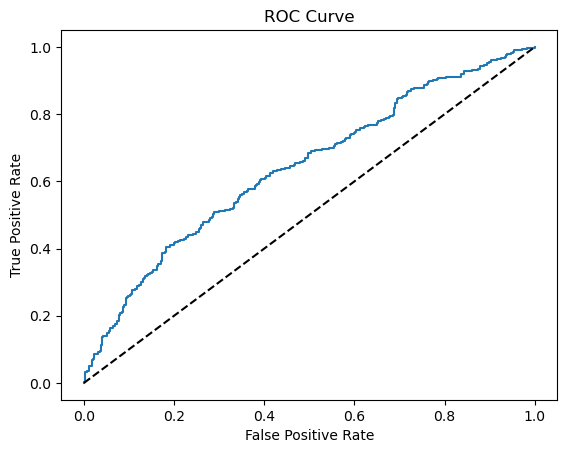

In [176]:
#plot ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test['profit_binary'], test['pred'])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [185]:
#Function to compute confusion matrix and prediction accuracy on test/train data
from sklearn.metrics import auc


def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))


Classification accuracy = 60.1%
Precision = 60.7%
TPR or Recall = 73.5%
FNR = 26.5%
FPR = 55.5%
ROC-AUC = 62.9%


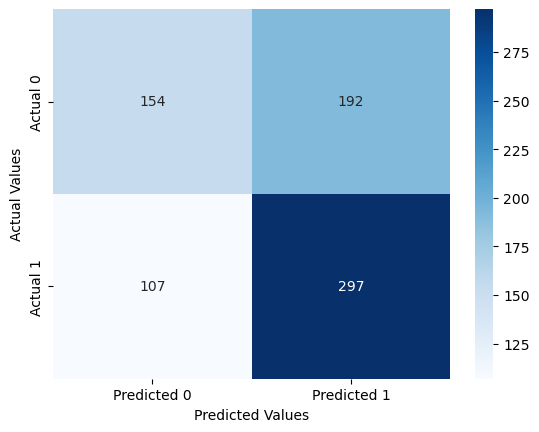

In [186]:
#run confusion_matrix_data like confusion_matrix_data(test,test.Outcome,logit_model_diabetes,0.3)
confusion_matrix_data(test,test.profit_binary,logistic_model,0.5)


In [158]:
#print equation model
print(logistic_model.summary())

                           Logit Regression Results                           
Dep. Variable:          profit_binary   No. Observations:                 2998
Model:                          Logit   Df Residuals:                     2968
Method:                           MLE   Df Model:                           29
Date:                Mon, 06 Mar 2023   Pseudo R-squ.:                  0.5105
Time:                        15:22:17   Log-Likelihood:                -1013.0
converged:                       True   LL-Null:                       -2069.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    13.0851        nan        nan        nan         nan         nan
director_high                 7.3422        nan        nan        nan         nan     

In [159]:
#list of significant predictors w p-value < 0.05

significant_list = logistic_model.pvalues[logistic_model.pvalues < 0.05].index.tolist()
significant_list

['comedy', 'documentary', 'horror', 'title_year', 'aspect_ratio']

## New Model

In [168]:
#new model w predictors_actors and 'comedy', 'documentary', 'horror', 'title_year', 'aspect_ratio'
predictors_actors = ['director_high', 'director_low', 'actor_1_high', 'actor_1_low']
new_model = smf.logit(formula='profit_binary ~ ' + ' + '.join(predictors_actors) + ' + ' + 'comedy' + ' + ' + 'documentary' + ' + ' + 'horror' + ' + ' + 'title_year' + ' + ' + 'aspect_ratio', data=train).fit()

#accuracy on test
new_model.summary()
test['pred'] = new_model.predict(test)
test['pred_binary'] = np.where(test['pred'] > 0.5, 1, 0)
accuracy = sum(test['pred_binary'] == test['profit_binary'])/len(test)
print(accuracy)



Optimization terminated successfully.
         Current function value: 0.487882
         Iterations 10
0.772


In [161]:
#model eq
print(new_model.summary())

                           Logit Regression Results                           
Dep. Variable:          profit_binary   No. Observations:                 2998
Model:                          Logit   Df Residuals:                     2988
Method:                           MLE   Df Model:                            9
Date:                Mon, 06 Mar 2023   Pseudo R-squ.:                  0.5066
Time:                        15:22:17   Log-Likelihood:                -1021.1
converged:                      False   LL-Null:                       -2069.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.3931   2.82e+06   4.39e-06      1.000   -5.53e+06    5.53e+06
director_high     6.9801        nan        nan        nan         nan         nan
director_low      5.4130        nan     

In [169]:
# Import RFE from scikit-learn
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Define the model to use
model = LogisticRegression()

# Combine predictors_actors and predictors_genre into one list
predictors = predictor_actor_new+ predictors_genre + standard_predictors
X_train = train[predictors]
y_train = train['profit_binary']

# Set the number of features to remove at each step
step = 1

# Initialize RFE with the logistic regression model and step size
rfe = RFE(estimator=model, n_features_to_select=step)

# Fit RFE on the training data
rfe.fit(X_train, y_train)

# Get the ranking of each feature
ranking = rfe.ranking_

# Create a list of selected features based on their ranking
selected_features = [predictors[i] for i in range(len(predictors)) if ranking[i] == 1]

# Fit the logistic regression model on the selected features
logistic_model_backwards = smf.logit(formula = 'profit_binary ~ ' + ' + '.join(selected_features), data = train).fit()

# Print the summary of the model
print(logistic_model_backwards.summary())


Optimization terminated successfully.
         Current function value: 0.690085
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          profit_binary   No. Observations:                 2998
Model:                          Logit   Df Residuals:                     2996
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 Mar 2023   Pseudo R-squ.:               0.0003165
Time:                        15:23:42   Log-Likelihood:                -2068.9
converged:                       True   LL-Null:                       -2069.5
Covariance Type:            nonrobust   LLR p-value:                    0.2524
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.1294      0.042      3.095      0.002       0.047      

In [170]:
#new model w jsut actor_3_low

log_model_2 = smf.logit(formula = 'profit_binary ~ actor_1_facebook_likes', data = train).fit()

# Print the summary of the model
print(log_model_2.summary())


Optimization terminated successfully.
         Current function value: 0.690085
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          profit_binary   No. Observations:                 2998
Model:                          Logit   Df Residuals:                     2996
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 Mar 2023   Pseudo R-squ.:               0.0003165
Time:                        15:25:05   Log-Likelihood:                -2068.9
converged:                       True   LL-Null:                       -2069.5
Covariance Type:            nonrobust   LLR p-value:                    0.2524
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.1294      0.042      3.095      0.002       0.047      

In [171]:
#accruacy on test
test['pred'] = log_model_2.predict(test)
test['pred_binary'] = np.where(test['pred'] > 0.5, 1, 0)
accuracy = sum(test['pred_binary'] == test['profit_binary'])/len(test)
print(accuracy)


0.5386666666666666


In [165]:
#coeff
print(log_model_2.params)

Intercept      1.771439
actor_3_low   -3.309000
dtype: float64


In [166]:
#frequncy coutnm for all actor columns
for i in predictors_actors:
    print(i)
    print(train[i].value_counts())
    print()



director_high
1    1845
0    1153
Name: director_high, dtype: int64

director_low
0    1845
1    1153
Name: director_low, dtype: int64

actor_1_high
1    1857
0    1141
Name: actor_1_high, dtype: int64

actor_1_low
0    1857
1    1141
Name: actor_1_low, dtype: int64

actor_2_high
1    1675
0    1323
Name: actor_2_high, dtype: int64

actor_2_low
0    1675
1    1323
Name: actor_2_low, dtype: int64

actor_3_high
1    1596
0    1402
Name: actor_3_high, dtype: int64

actor_3_low
0    1596
1    1402
Name: actor_3_low, dtype: int64



In [167]:
#effect of documnebntary horror and comedy on profit
for i in predictors_genre:
    print(i)
    print(train[i].value_counts())
    print()

action
0    2236
1     762
Name: action, dtype: int64

biography
0    2809
1     189
Name: biography, dtype: int64

comedy
0    1817
1    1181
Name: comedy, dtype: int64

crime
0    2427
1     571
Name: crime, dtype: int64

documentary
0    2964
1      34
Name: documentary, dtype: int64

drama
1    1504
0    1494
Name: drama, dtype: int64

history
0    2875
1     123
Name: history, dtype: int64

horror
0    2687
1     311
Name: horror, dtype: int64

music
0    2881
1     117
Name: music, dtype: int64

musical
0    2912
1      86
Name: musical, dtype: int64

mystery
0    2692
1     306
Name: mystery, dtype: int64

romance
0    2308
1     690
Name: romance, dtype: int64

sport
0    2880
1     118
Name: sport, dtype: int64

thriller
0    2105
1     893
Name: thriller, dtype: int64

war
0    2874
1     124
Name: war, dtype: int64

western
0    2959
1      39
Name: western, dtype: int64

